In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import torch.nn.functional as F
from PIL import Image
import os
from torch.utils.data import random_split
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
class CustomDataset(Dataset):
    
    def __init__(self, image_patches_csv, images_dir, transform=None):
        self.image_patches_df = pd.read_csv(image_patches_csv)
        self.images_dir = images_dir
        self.transform = transform

        # Filter out invalid entries
        self.valid_samples = []
        
        for index, row in self.image_patches_df.iterrows():
            img_id = row['ID'].replace('.', '/') 
            img_path = os.path.join(self.images_dir, img_id + '.png')

            # Check if the image exists and the 'Presence' is not 0
            if os.path.exists(img_path) and row['Presence'] != 0:
                label = row['Presence']
                # Convert labels from -1/1 to 0/1 for CrossEntropyLoss
                label = 0 if label == -1 else 1
                self.valid_samples.append((img_path, label))                             
        
    def __len__(self):
        return len(self.valid_samples)

    def __getitem__(self, idx):
        image_path, label = self.valid_samples[idx]
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        
        return image, label
    
    def __proba__(self):
        return(self.valid_entries) 

In [4]:
image_patches_csv = "C:/Users/alexx/OneDrive/Escriptori/window_metadata.csv" 
images_dir = "C:/Users/alexx/OneDrive/Escriptori/AnnotatedPatches/AnnotatedPatches/"
transforms = transforms.Compose([transforms.RandomHorizontalFlip(), transforms.RandomRotation(15), transforms.Resize((224, 224)), transforms.ToTensor()])

custom_dataset = CustomDataset(image_patches_csv=image_patches_csv, images_dir=images_dir, transform=transforms)

In [5]:
# Dividing into Training and testing.

train_size = int(0.8 * len(custom_dataset))
test_size = len(custom_dataset) - train_size
train_dataset, test_dataset = random_split(custom_dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [6]:
CNN_types = {"11_CNN": [64, "M", 128, "M", 256, 256, "M", 512, 512, "M", 512, 512, "M"]}

class scratch_CNN(nn.Module):
    def __init__(self, in_channels=3, num_classes=2):
        super(scratch_CNN, self).__init__()
        self.in_channels = in_channels
        self.conv_layers = self.create_conv_layers(CNN_types["11_CNN"])

        self.fcs = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, num_classes),
        )
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fcs(x)
        return x

    def create_conv_layers(self, architecture):
        layers = []
        in_channels = self.in_channels

        for x in architecture:
            if type(x) == int:
                out_channels = x

                layers += [
                    nn.Conv2d(
                        in_channels=in_channels,
                        out_channels=out_channels,
                        kernel_size=(3, 3),
                        stride=(1, 1),
                        padding=(1, 1),
                    ),
                    nn.BatchNorm2d(x), # Original does not include Batch normalization because it did not exist at that time, but may improve performance!
                    nn.ReLU(),
                ]
                in_channels = x
            elif x == "M":
                layers += [nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))]

        return nn.Sequential(*layers)

In [7]:

# Function to train the model
def train_model(model, criterion, optimizer, train_loader, num_epochs = 12):
    loss_history = []
    for epoch in range(num_epochs):
        model.train()  
        
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        loss_history.append(epoch_loss)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)

        print(f'Epoch {epoch}/{num_epochs - 1} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    return model, loss_history

In [8]:
model = scratch_CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
# Train the model
model, loss_history = train_model(model, criterion, optimizer, train_loader, num_epochs=11)

Epoch 0/10 Loss: 0.5576 Acc: 0.8255
Epoch 1/10 Loss: 0.3382 Acc: 0.8853
Epoch 2/10 Loss: 0.2146 Acc: 0.9342
Epoch 3/10 Loss: 0.1513 Acc: 0.9571
Epoch 4/10 Loss: 0.1128 Acc: 0.9601
Epoch 5/10 Loss: 0.0991 Acc: 0.9671
Epoch 6/10 Loss: 0.0762 Acc: 0.9751
Epoch 7/10 Loss: 0.1128 Acc: 0.9771
Epoch 8/10 Loss: 0.0818 Acc: 0.9721
Epoch 9/10 Loss: 0.0783 Acc: 0.9761
Epoch 10/10 Loss: 0.0613 Acc: 0.9791


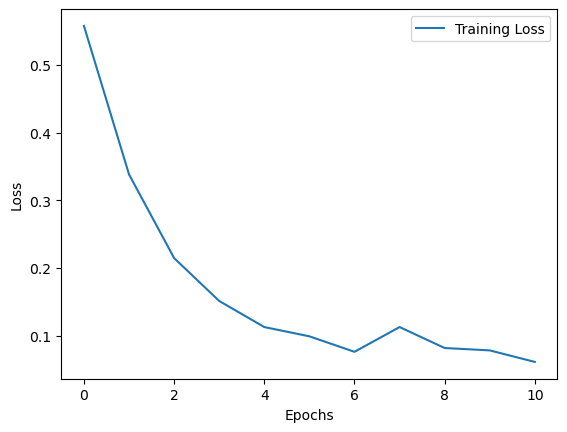

In [9]:
import matplotlib.pyplot as plt
plt.plot(loss_history, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [10]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Function to get predictions and true labels
def get_all_preds_labels(model, data_loader):
    all_preds = torch.tensor([])
    all_labels = torch.tensor([])
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds = torch.cat((all_preds, preds.cpu()), dim=0)
            all_labels = torch.cat((all_labels, labels.cpu()), dim=0)
            
    return all_preds.numpy(), all_labels.numpy()

preds, labels = get_all_preds_labels(model, test_loader)

conf_matrix = confusion_matrix(labels, preds)


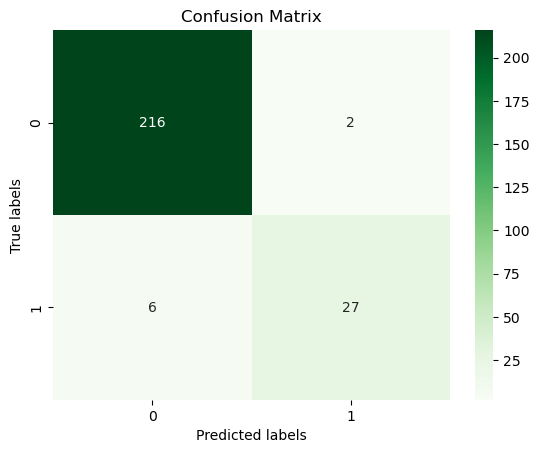

In [11]:
import seaborn as sns

sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Greens')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()
